**ROUGE**

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import re
from typing import List, Tuple, Dict
import unicodedata

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

class BengaliRougeCalculator:
    """
    Custom ROUGE calculator for Bengali text summarization evaluation
    Supports ROUGE-1, ROUGE-2, and ROUGE-L metrics
    """

    def __init__(self):
        self.bengali_punctuation = '।,;:!?()[]{}""''…—–-'

    def normalize_text(self, text: str) -> str:
        """
        Normalize Bengali text by removing extra whitespace and punctuation
        """
        if not text or pd.isna(text):
            return ""

        # Convert to string if not already
        text = str(text)

        # Normalize Unicode characters
        text = unicodedata.normalize('NFC', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)

        # Remove punctuation but keep Bengali text
        text = re.sub(f'[{re.escape(self.bengali_punctuation)}]', '', text)

        return text.strip()

    def tokenize_bengali(self, text: str) -> List[str]:
        """
        Tokenize Bengali text into words
        """
        normalized_text = self.normalize_text(text)
        if not normalized_text:
            return []

        # Split by whitespace to get words
        tokens = normalized_text.split()

        # Filter out empty tokens
        tokens = [token for token in tokens if token.strip()]

        return tokens

    def get_ngrams(self, tokens: List[str], n: int) -> List[Tuple[str, ...]]:
        """
        Generate n-grams from tokens
        """
        if len(tokens) < n:
            return []

        ngrams = []
        for i in range(len(tokens) - n + 1):
            ngram = tuple(tokens[i:i + n])
            ngrams.append(ngram)

        return ngrams

    def calculate_rouge_n(self, reference: str, candidate: str, n: int) -> Dict[str, float]:
        """
        Calculate ROUGE-N score (precision, recall, f1)
        """
        ref_tokens = self.tokenize_bengali(reference)
        cand_tokens = self.tokenize_bengali(candidate)

        if not ref_tokens or not cand_tokens:
            return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

        ref_ngrams = self.get_ngrams(ref_tokens, n)
        cand_ngrams = self.get_ngrams(cand_tokens, n)

        if not ref_ngrams or not cand_ngrams:
            return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

        # Count ngrams
        ref_counter = Counter(ref_ngrams)
        cand_counter = Counter(cand_ngrams)

        # Calculate overlap
        overlap = 0
        for ngram in cand_counter:
            if ngram in ref_counter:
                overlap += min(cand_counter[ngram], ref_counter[ngram])

        # Calculate precision and recall
        precision = overlap / len(cand_ngrams) if cand_ngrams else 0.0
        recall = overlap / len(ref_ngrams) if ref_ngrams else 0.0

        # Calculate F1 score
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    def lcs_length(self, tokens1: List[str], tokens2: List[str]) -> int:
        """
        Calculate Longest Common Subsequence length
        """
        m, n = len(tokens1), len(tokens2)

        # Create DP table
        dp = [[0] * (n + 1) for _ in range(m + 1)]

        # Fill DP table
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if tokens1[i-1] == tokens2[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])

        return dp[m][n]

    def calculate_rouge_l(self, reference: str, candidate: str) -> Dict[str, float]:
        """
        Calculate ROUGE-L score using Longest Common Subsequence
        """
        ref_tokens = self.tokenize_bengali(reference)
        cand_tokens = self.tokenize_bengali(candidate)

        if not ref_tokens or not cand_tokens:
            return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

        lcs_len = self.lcs_length(ref_tokens, cand_tokens)

        precision = lcs_len / len(cand_tokens) if cand_tokens else 0.0
        recall = lcs_len / len(ref_tokens) if ref_tokens else 0.0

        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    def calculate_rouge_scores(self, reference: str, candidate: str) -> Dict[str, Dict[str, float]]:
        """
        Calculate all ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L)
        """
        rouge_1 = self.calculate_rouge_n(reference, candidate, 1)
        rouge_2 = self.calculate_rouge_n(reference, candidate, 2)
        rouge_l = self.calculate_rouge_l(reference, candidate)

        return {
            'rouge-1': rouge_1,
            'rouge-2': rouge_2,
            'rouge-l': rouge_l
        }

# Function to load data from Google Drive
def load_data_from_drive(file_path: str) -> pd.DataFrame:
    """
    Load Excel file from Google Drive
    """
    try:
        df = pd.read_excel(file_path)
        print(f"Data loaded successfully! Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# Function to calculate ROUGE scores for entire dataset
def evaluate_dataset(df: pd.DataFrame, reference_col: str = 'summary',
                    candidate_col: str = 'generated_summary') -> pd.DataFrame:
    """
    Calculate ROUGE scores for the entire dataset
    """
    rouge_calc = BengaliRougeCalculator()

    # Initialize lists to store results
    rouge_1_f1 = []
    rouge_1_precision = []
    rouge_1_recall = []
    rouge_2_f1 = []
    rouge_2_precision = []
    rouge_2_recall = []
    rouge_l_f1 = []
    rouge_l_precision = []
    rouge_l_recall = []

    print("Calculating ROUGE scores...")

    for idx, row in df.iterrows():
        if idx % 100 == 0:  # Progress indicator
            print(f"Processing row {idx}/{len(df)}")

        reference = row[reference_col]
        candidate = row[candidate_col]

        # Calculate ROUGE scores
        scores = rouge_calc.calculate_rouge_scores(reference, candidate)

        # Store results
        rouge_1_f1.append(scores['rouge-1']['f1'])
        rouge_1_precision.append(scores['rouge-1']['precision'])
        rouge_1_recall.append(scores['rouge-1']['recall'])

        rouge_2_f1.append(scores['rouge-2']['f1'])
        rouge_2_precision.append(scores['rouge-2']['precision'])
        rouge_2_recall.append(scores['rouge-2']['recall'])

        rouge_l_f1.append(scores['rouge-l']['f1'])
        rouge_l_precision.append(scores['rouge-l']['precision'])
        rouge_l_recall.append(scores['rouge-l']['recall'])

    # Add scores to dataframe
    df_with_scores = df.copy()
    df_with_scores['rouge_1_f1'] = rouge_1_f1
    df_with_scores['rouge_1_precision'] = rouge_1_precision
    df_with_scores['rouge_1_recall'] = rouge_1_recall
    df_with_scores['rouge_2_f1'] = rouge_2_f1
    df_with_scores['rouge_2_precision'] = rouge_2_precision
    df_with_scores['rouge_2_recall'] = rouge_2_recall
    df_with_scores['rouge_l_f1'] = rouge_l_f1
    df_with_scores['rouge_l_precision'] = rouge_l_precision
    df_with_scores['rouge_l_recall'] = rouge_l_recall

    return df_with_scores

# Function to display summary statistics
def display_summary_stats(df: pd.DataFrame):
    """
    Display summary statistics of ROUGE scores
    """
    print("\n" + "="*50)
    print("ROUGE SCORE SUMMARY STATISTICS")
    print("="*50)

    rouge_columns = [col for col in df.columns if col.startswith('rouge_')]

    for col in rouge_columns:
        mean_score = df[col].mean()
        std_score = df[col].std()
        median_score = df[col].median()

        print(f"\n{col.upper()}:")
        print(f"  Mean: {mean_score:.4f}")
        print(f"  Std:  {std_score:.4f}")
        print(f"  Median: {median_score:.4f}")

    # Overall summary
    print(f"\n{'='*50}")
    print("OVERALL ROUGE SCORES (F1):")
    print(f"{'='*50}")
    print(f"ROUGE-1 F1: {df['rouge_1_f1'].mean():.4f} ± {df['rouge_1_f1'].std():.4f}")
    print(f"ROUGE-2 F1: {df['rouge_2_f1'].mean():.4f} ± {df['rouge_2_f1'].std():.4f}")
    print(f"ROUGE-L F1: {df['rouge_l_f1'].mean():.4f} ± {df['rouge_l_f1'].std():.4f}")

# Main execution
if __name__ == "__main__":
    # Update this path to your Google Drive file location
    # Example: '/content/drive/MyDrive/your_file.xlsx'
    file_path = '/content/drive/MyDrive/Thesis_Dataset/test_Qwen_raw.xlsx'  # Update this path

    # Load data
    print("Loading data from Google Drive...")
    df = load_data_from_drive(file_path)

    if df is not None:
        # Display first few rows
        print("\nFirst 5 rows of the dataset:")
        print(df.head())

        # Calculate ROUGE scores
        df_with_scores = evaluate_dataset(df, 'summary', 'generated_summary')

        # Display summary statistics
        display_summary_stats(df_with_scores)

        # Save results back to Google Drive
        output_path = '/content/drive/MyDrive/Thesis_Dataset/ROUGE_Qwen_raw.xlsx'
        df_with_scores.to_excel(output_path, index=False)
        print(f"\nResults saved to: {output_path}")

        # Sample results for verification
        print("\nSample ROUGE scores for first 5 examples:")
        sample_cols = ['rouge_1_f1', 'rouge_2_f1', 'rouge_l_f1']
        print(df_with_scores[sample_cols].head())

    else:
        print("Failed to load data. Please check the file path and try again.")

# Example usage for single pair evaluation
def test_single_example():
    """
    Test with a single Bengali text-summary pair
    """
    rouge_calc = BengaliRougeCalculator()

    # Example Bengali text and summary
    reference = "আজকে আবহাওয়া খুবই সুন্দর। আকাশ পরিষ্কার এবং রোদ উজ্জ্বল।"
    candidate = "আজ আবহাওয়া সুন্দর। আকাশ পরিষ্কার।"

    scores = rouge_calc.calculate_rouge_scores(reference, candidate)

    print("Single Example Test:")
    print(f"Reference: {reference}")
    print(f"Candidate: {candidate}")
    print(f"ROUGE-1: {scores['rouge-1']}")
    print(f"ROUGE-2: {scores['rouge-2']}")
    print(f"ROUGE-L: {scores['rouge-l']}")

# Uncomment the line below to test with a single example
# test_single_example()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from Google Drive...
Data loaded successfully! Shape: (13, 3)
Columns: ['text', 'summary', 'generated_summary']

First 5 rows of the dataset:
                                                text  \
0  আপনাদের আমি মাইক্রোপ্রসেসর ক্লাস শেষ হয়ে গেছে...   
1  অন মানে হচ্ছে ওয়ান কোন কিছু অফ। মানে এই দুটোর...   
2  সিকুয়েন্স নামটা শুনেই বুঝতে পারতেছি কি যে একট...   
3  মানে স্লাইড নিজের একটু জাস্ট রিডিং পড়ে তারপর ...   
4  সি এর ফাংশন বের করার জন্য ওয়ান কোথায় আছে? এখ...   

                                             summary  \
0  এই লেকচারে শিক্ষক ডিএসডি কোর্সের প্রাথমিক পরিচ...   
1  এই অংশে শিক্ষক ব্যাখ্যা করেন যে ডিজিটাল সিস্টে...   
2  এই অংশে শিক্ষক সিকুয়েন্সিয়াল সার্কিট সম্পর্ক...   
3  এই অংশে শিক্ষক হাফ অ্যাডার এবং ফুল অ্যাডারের প...   
4  এই অংশে শিক্ষক ফুল অ্যাডার এবং হাফ অ্যাডারের ক...   

                                   generat

**MoverScore**

In [ ]:
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple, Optional
import re
import unicodedata
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import AutoTokenizer, AutoModel
import warnings
import os
warnings.filterwarnings('ignore')

# Set environment variables for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install -q transformers torch scipy scikit-learn

class BengaliMoverScoreCalculator:
    """
    Custom MoverScore calculator for Bengali text summarization evaluation
    Uses Earth Mover's Distance (Wasserstein distance) with Bengali BERT embeddings
    """

    def __init__(self, model_name: str = "sagorsarker/bangla-bert-base", force_cpu: bool = False):
        """
        Initialize MoverScore calculator with Bengali BERT model

        Args:
            model_name: Hugging Face model name for Bengali BERT
            force_cpu: Force CPU usage to avoid CUDA errors
        """
        self.bengali_punctuation = '।,;:!?()[]{}""''…—–-'

        # Force CPU if requested or if CUDA is causing issues
        if force_cpu or not torch.cuda.is_available():
            self.device = torch.device('cpu')
            print("Using CPU (forced or CUDA unavailable)")
        else:
            self.device = torch.device('cuda')
            print(f"Using device: {self.device}")

        # Load Bengali BERT model and tokenizer
        try:
            print(f"Loading Bengali BERT model: {model_name}")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModel.from_pretrained(model_name)

            # Move to device with error handling
            try:
                self.model = self.model.to(self.device)
                print(f"Model successfully moved to {self.device}")
            except RuntimeError as e:
                print(f"Error moving model to {self.device}: {e}")
                print("Falling back to CPU...")
                self.device = torch.device('cpu')
                self.model = self.model.to(self.device)

            self.model.eval()
            print("Model loaded successfully!")

        except Exception as e:
            print(f"Error loading model: {e}")
            print("Falling back to multilingual BERT...")
            self.tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
            self.model = AutoModel.from_pretrained("bert-base-multilingual-cased")
            self.model = self.model.to(self.device)
            self.model.eval()

        # Cache for embeddings to speed up computation
        self.embedding_cache = {}

        # Get model's hidden size
        self.hidden_size = self.model.config.hidden_size
        print(f"Model hidden size: {self.hidden_size}")

    def normalize_text(self, text: str) -> str:
        """
        Normalize Bengali text by removing extra whitespace and punctuation
        """
        try:
            if not text or pd.isna(text):
                return ""

            # Convert to string if not already
            text = str(text)

            # Normalize Unicode characters
            text = unicodedata.normalize('NFC', text)

            # Remove extra whitespace
            text = re.sub(r'\s+', ' ', text)

            # Remove punctuation but keep Bengali text
            text = re.sub(f'[{re.escape(self.bengali_punctuation)}]', '', text)

            return text.strip()
        except Exception as e:
            print(f"Error normalizing text: {e}")
            return ""

    def tokenize_bengali(self, text: str) -> List[str]:
        """
        Tokenize Bengali text into words
        """
        try:
            normalized_text = self.normalize_text(text)
            if not normalized_text:
                return []

            # Split by whitespace to get words
            tokens = normalized_text.split()

            # Filter out empty tokens and limit length
            tokens = [token for token in tokens if token.strip()]

            # Limit number of tokens to prevent memory issues
            if len(tokens) > 300:
                tokens = tokens[:300]
                print(f"Warning: Truncated tokens to 300 words")

            return tokens
        except Exception as e:
            print(f"Error tokenizing text: {e}")
            return []

    def safe_tokenize(self, text: str) -> Dict:
        """
        Safely tokenize text with comprehensive error handling
        """
        try:
            # Ensure text is reasonable length
            if len(text) > 512:
                text = text[:512]

            # Tokenize with safe parameters
            inputs = self.tokenizer(
                text,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=256,  # Reduced max length
                return_attention_mask=True,
                add_special_tokens=True
            )

            # Validate tokenization results
            if inputs['input_ids'].numel() == 0:
                print("Warning: Empty tokenization result")
                return None

            # Check for invalid token IDs
            vocab_size = self.tokenizer.vocab_size
            if torch.any(inputs['input_ids'] >= vocab_size) or torch.any(inputs['input_ids'] < 0):
                print(f"Warning: Invalid token IDs detected. Vocab size: {vocab_size}")
                # Replace invalid tokens with UNK token
                inputs['input_ids'] = torch.clamp(inputs['input_ids'], 0, vocab_size - 1)

            return inputs

        except Exception as e:
            print(f"Error in safe_tokenize: {e}")
            return None

    def get_word_embeddings(self, tokens: List[str]) -> np.ndarray:
        """
        Get BERT embeddings for Bengali words with comprehensive error handling
        """
        if not tokens:
            return np.array([]).reshape(0, self.hidden_size)

        # Check cache first
        cache_key = " ".join(tokens)
        if cache_key in self.embedding_cache:
            return self.embedding_cache[cache_key]

        try:
            text = " ".join(tokens)

            # Safe tokenization
            inputs = self.safe_tokenize(text)
            if inputs is None:
                return np.array([]).reshape(0, self.hidden_size)

            # Move to device with error handling
            try:
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
            except RuntimeError as e:
                print(f"Error moving inputs to device: {e}")
                # Force CPU usage
                self.device = torch.device('cpu')
                self.model = self.model.to(self.device)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}

            # Get embeddings with comprehensive error handling
            embeddings = None
            try:
                with torch.no_grad():
                    # Validate inputs before forward pass
                    input_ids = inputs['input_ids']
                    attention_mask = inputs['attention_mask']

                    if input_ids.shape[1] == 0:
                        print("Warning: Empty input_ids")
                        return np.array([]).reshape(0, self.hidden_size)

                    # Forward pass
                    outputs = self.model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    )
                    embeddings = outputs.last_hidden_state

            except RuntimeError as cuda_error:
                print(f"CUDA error in model forward pass: {cuda_error}")
                print("Switching to CPU...")

                # Move everything to CPU
                self.device = torch.device('cpu')
                self.model = self.model.cpu()
                inputs = {k: v.cpu() for k, v in inputs.items()}

                # Retry on CPU
                with torch.no_grad():
                    outputs = self.model(**inputs)
                    embeddings = outputs.last_hidden_state

            if embeddings is None:
                return np.array([]).reshape(0, self.hidden_size)

            # Process embeddings safely
            word_embeddings = []

            # Simple approach: use [CLS] token and average all tokens
            if embeddings.shape[1] > 1:
                # Skip [CLS] and [SEP] tokens, average the rest
                token_embeddings = embeddings[0, 1:-1, :]  # Skip first and last tokens

                if token_embeddings.shape[0] > 0:
                    # Group tokens by words (simple approach)
                    tokens_per_word = max(1, token_embeddings.shape[0] // len(tokens))

                    for i in range(len(tokens)):
                        start_idx = i * tokens_per_word
                        end_idx = min((i + 1) * tokens_per_word, token_embeddings.shape[0])

                        if start_idx < token_embeddings.shape[0]:
                            word_embedding = token_embeddings[start_idx:end_idx, :].mean(dim=0)
                            word_embeddings.append(word_embedding.cpu().numpy())

            # Fallback: use [CLS] token for each word
            if not word_embeddings:
                cls_embedding = embeddings[0, 0, :].cpu().numpy()
                word_embeddings = [cls_embedding for _ in tokens]

            if not word_embeddings:
                return np.array([]).reshape(0, self.hidden_size)

            word_embeddings = np.array(word_embeddings)

            # Validate embeddings
            if np.isnan(word_embeddings).any() or np.isinf(word_embeddings).any():
                print("Warning: NaN or Inf values detected in embeddings")
                word_embeddings = np.nan_to_num(word_embeddings, nan=0.0, posinf=1.0, neginf=-1.0)

            # Cache the result
            self.embedding_cache[cache_key] = word_embeddings

            return word_embeddings

        except Exception as e:
            print(f"Error in get_word_embeddings: {e}")
            return np.array([]).reshape(0, self.hidden_size)

    def calculate_optimal_transport_distance(self, embeddings1: np.ndarray,
                                           embeddings2: np.ndarray) -> float:
        """
        Calculate optimal transport distance between two sets of embeddings
        """
        if embeddings1.shape[0] == 0 or embeddings2.shape[0] == 0:
            return 0.0

        try:
            # Validate embeddings
            if np.isnan(embeddings1).any() or np.isnan(embeddings2).any():
                print("Warning: NaN values in embeddings")
                return 0.0

            # Calculate cosine similarity matrix
            similarity_matrix = cosine_similarity(embeddings1, embeddings2)

            # Validate similarity matrix
            if np.isnan(similarity_matrix).any() or np.isinf(similarity_matrix).any():
                print("Warning: Invalid similarity matrix")
                return 0.0

            # Convert similarity to distance
            distance_matrix = 1 - similarity_matrix
            distance_matrix = np.maximum(distance_matrix, 0)
            distance_matrix = np.minimum(distance_matrix, 2)

            # Handle different sized matrices
            if embeddings1.shape[0] == embeddings2.shape[0]:
                row_indices, col_indices = linear_sum_assignment(distance_matrix)
                optimal_distance = distance_matrix[row_indices, col_indices].mean()
            else:
                # Different sizes - use approximation
                max_size = max(embeddings1.shape[0], embeddings2.shape[0])
                padded_matrix = np.ones((max_size, max_size))
                padded_matrix[:distance_matrix.shape[0], :distance_matrix.shape[1]] = distance_matrix

                row_indices, col_indices = linear_sum_assignment(padded_matrix)

                valid_assignments = [
                    (r, c) for r, c in zip(row_indices, col_indices)
                    if r < embeddings1.shape[0] and c < embeddings2.shape[0]
                ]

                if valid_assignments:
                    optimal_distance = np.mean([distance_matrix[r, c] for r, c in valid_assignments])
                else:
                    optimal_distance = 1.0

            mover_score = 1 - optimal_distance
            mover_score = np.clip(mover_score, 0.0, 1.0)

            return float(mover_score)

        except Exception as e:
            print(f"Error in optimal transport calculation: {e}")
            return 0.0

    def calculate_mover_score(self, reference: str, candidate: str) -> float:
        """
        Calculate MoverScore between reference and candidate text
        """
        try:
            # Validate inputs
            if not reference or not candidate or pd.isna(reference) or pd.isna(candidate):
                return 0.0

            # Tokenize texts
            ref_tokens = self.tokenize_bengali(reference)
            cand_tokens = self.tokenize_bengali(candidate)

            if not ref_tokens or not cand_tokens:
                return 0.0

            # Get embeddings
            ref_embeddings = self.get_word_embeddings(ref_tokens)
            cand_embeddings = self.get_word_embeddings(cand_tokens)

            if ref_embeddings.shape[0] == 0 or cand_embeddings.shape[0] == 0:
                return 0.0

            # Calculate MoverScore
            score = self.calculate_optimal_transport_distance(ref_embeddings, cand_embeddings)

            return score

        except Exception as e:
            print(f"Error calculating MoverScore: {e}")
            return 0.0

# Function to load data from Google Drive
def load_data_from_drive(file_path: str) -> pd.DataFrame:
    """
    Load Excel file from Google Drive
    """
    try:
        df = pd.read_excel(file_path)
        print(f"Data loaded successfully! Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# Function to calculate MoverScore for entire dataset
def evaluate_dataset_mover(df: pd.DataFrame, reference_col: str = 'summary',
                          candidate_col: str = 'generated_summary',
                          model_name: str = "sagorsarker/bangla-bert-base",
                          force_cpu: bool = True) -> pd.DataFrame:
    """
    Calculate MoverScore for the entire dataset
    """
    print(f"Initializing MoverScore calculator (force_cpu={force_cpu})...")
    mover_calc = BengaliMoverScoreCalculator(model_name, force_cpu=force_cpu)

    mover_scores = []

    print("Calculating MoverScore...")
    print(f"Processing {len(df)} examples...")

    # Process one by one with extensive error handling
    for idx, row in df.iterrows():
        if idx % 10 == 0:
            print(f"Processing row {idx}/{len(df)}")

        try:
            reference = row[reference_col]
            candidate = row[candidate_col]

            # Skip if either is empty
            if pd.isna(reference) or pd.isna(candidate):
                mover_scores.append(0.0)
                continue

            # Calculate MoverScore
            score = mover_calc.calculate_mover_score(reference, candidate)
            mover_scores.append(score)

        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            mover_scores.append(0.0)

        # Clear cache every 50 examples
        if idx % 50 == 0 and idx > 0:
            mover_calc.embedding_cache.clear()
            print(f"Cleared cache at row {idx}")

    # Add scores to dataframe
    df_with_scores = df.copy()
    df_with_scores['mover_score'] = mover_scores

    return df_with_scores

# Function to display MoverScore statistics
def display_mover_stats(df: pd.DataFrame):
    """
    Display summary statistics of MoverScore
    """
    print("\n" + "="*50)
    print("MOVERSCORE SUMMARY STATISTICS")
    print("="*50)

    mean_score = df['mover_score'].mean()
    std_score = df['mover_score'].std()
    median_score = df['mover_score'].median()
    min_score = df['mover_score'].min()
    max_score = df['mover_score'].max()

    print(f"\nMOVERSCORE:")
    print(f"  Mean: {mean_score:.4f}")
    print(f"  Std:  {std_score:.4f}")
    print(f"  Median: {median_score:.4f}")
    print(f"  Min: {min_score:.4f}")
    print(f"  Max: {max_score:.4f}")

    # Distribution analysis
    print(f"\nDISTRIBUTION ANALYSIS:")
    print(f"  Scores > 0.8: {(df['mover_score'] > 0.8).sum()} ({(df['mover_score'] > 0.8).mean()*100:.1f}%)")
    print(f"  Scores > 0.6: {(df['mover_score'] > 0.6).sum()} ({(df['mover_score'] > 0.6).mean()*100:.1f}%)")
    print(f"  Scores > 0.4: {(df['mover_score'] > 0.4).sum()} ({(df['mover_score'] > 0.4).mean()*100:.1f}%)")

    print(f"\n{'='*50}")
    print("OVERALL MOVERSCORE:")
    print(f"{'='*50}")
    print(f"MoverScore: {mean_score:.4f} ± {std_score:.4f}")

# Function to test single example
def test_single_mover_example(model_name: str = "sagorsarker/bangla-bert-base"):
    """
    Test MoverScore with a single Bengali text-summary pair
    """
    print("Testing single example with CPU...")
    mover_calc = BengaliMoverScoreCalculator(model_name, force_cpu=True)

    reference = "আজকে আবহাওয়া খুবই সুন্দর। আকাশ পরিষ্কার এবং রোদ উজ্জ্বল।"
    candidate = "আজ আবহাওয়া চমৎকার। পরিষ্কার আকাশে সূর্যের আলো।"

    score = mover_calc.calculate_mover_score(reference, candidate)

    print("Single Example MoverScore Test:")
    print(f"Reference: {reference}")
    print(f"Candidate: {candidate}")
    print(f"MoverScore: {score:.4f}")

    return score

# Main execution
if __name__ == "__main__":
    # Available Bengali BERT models
    bengali_models = [
        "sagorsarker/bangla-bert-base",
        "csebuetnlp/banglabert",
        "banglabert/bangla-bert-base"
    ]

    selected_model = bengali_models[0]
    file_path = '/content/drive/MyDrive/Thesis_Dataset/test_banglaT5_raw.xlsx'

    # Test single example first
    print("Testing single example...")
    test_single_mover_example(selected_model)

    # Load data
    print(f"\nLoading data from Google Drive...")
    df = load_data_from_drive(file_path)

    if df is not None:
        print(f"\nFirst 5 rows of the dataset:")
        print(df.head())

        # Calculate MoverScore with CPU only
        print(f"\nUsing Bengali BERT model: {selected_model} (CPU only)")
        df_with_scores = evaluate_dataset_mover(df, 'summary', 'generated_summary', selected_model, force_cpu=True)

        display_mover_stats(df_with_scores)

        # Save results
        output_path = '/content/drive/MyDrive/Thesis_Dataset/mover_score_banglaT5_raw.xlsx'
        df_with_scores.to_excel(output_path, index=False)
        print(f"\nResults saved to: {output_path}")

        print(f"\nSample MoverScore for first 10 examples:")
        print(df_with_scores['mover_score'].head(10).tolist())

        if 'rouge_1_f1' in df_with_scores.columns:
            print(f"\nCorrelation with ROUGE-1 F1: {df_with_scores['mover_score'].corr(df_with_scores['rouge_1_f1']):.3f}")

        if 'bert_score' in df_with_scores.columns:
            print(f"Correlation with BERTScore: {df_with_scores['mover_score'].corr(df_with_scores['bert_score']):.3f}")

    else:
        print("Failed to load data. Please check the file path and try again.")

print("\n" + "="*50)
print("FIXED VERSION NOTES:")
print("="*50)
print("- Forces CPU usage to avoid CUDA errors")
print("- Comprehensive error handling and debugging")
print("- Simplified embedding extraction")
print("- Reduced memory usage")
print("- Token validation and bounds checking")
print("- Graceful fallback mechanisms")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 826.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.6 MB/s eta 0:00:00
Testing single example...
Testing single example with CPU...
Using CPU (f

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Model successfully moved to cpu
Model loaded successfully!
Model hidden size: 768
Single Example MoverScore Test:
Reference: আজকে আবহাওয়া খুবই সুন্দর। আকাশ পরিষ্কার এবং রোদ উজ্জ্বল।
Candidate: আজ আবহাওয়া চমৎকার। পরিষ্কার আকাশে সূর্যের আলো।
MoverScore: 0.6358

Loading data from Google Drive...
Data loaded successfully! Shape: (1014, 3)
Columns: ['text', 'summary', 'generated_summary']

First 5 rows of the dataset:
                                                text  \
0  তাইলে যদি এই টোটাল দৈর্ঘ্যটা আমাদের এল হয় তাই...   
1  আর ঘূর্ণন গতির ক্ষেত্রে স্বাধীনতার মাত্রা দুইট...   
2  টু ইকুয়াল টু এ কস থিটা এক্স আর টু টাকেই মাত্র...   
3  এখানে যদি এমন হয় আমরা চার কেজি নিয়ে নেই তো এ...   
4  এক্স আর ওয়াই এর সহগ ইন্টারচেঞ্জ হবে মাঝখানের ...   

                                             summary  \
0  দোলকের উপর বাতাসের ক্রিয়া এবং তার উচ্চতার পরি...   
1  এই অংশে গ্যাসের ডিগ্রি অফ ফ্রিডম এবং তার সাথে ...   
2  এখানে মূলত ভেক্টরের এক্স অক্ষের অংশ এবং তার গু...   
3  এখানে, যদি আমরা চ

KeyboardInterrupt: 

**Factual** **Consistency**

In [ ]:
# Optimized FactCC, DAE, and SummaC Implementation for Bangla Abstractive Summaries
# Google Colab Setup - Bangla Optimized Version

# Step 1: Install required packages
!pip install pandas openpyxl transformers torch sentence-transformers
!pip install -q datasets evaluate spacy stanza
!pip install nltk scikit-learn numpy
!pip install bnltk
!pip install polyglot pyicu pycld2

# Step 2: Mount Google Drive and Import Libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
import nltk
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict, Counter
import unicodedata

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Step 3: Load your dataset
file_path = '/content/drive/MyDrive/Thesis_Dataset/test_data_with_summaries_NLLB_12.xlsx'  # Update this path
df = pd.read_excel(file_path)

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Step 4: Enhanced Bangla text preprocessing
def preprocess_bangla_text(text):
    """Enhanced preprocessing for Bangla text"""
    if pd.isna(text):
        return ""

    text = str(text).strip()

    # Normalize unicode characters
    text = unicodedata.normalize('NFC', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Keep only Bangla characters, numbers, and basic punctuation
    text = re.sub(r'[^\u0980-\u09FF\u0964-\u0965\s\.\,\?\!\;\:\d\s]', '', text)

    return text

def bangla_sentence_tokenize(text):
    """Improved Bangla sentence tokenization"""
    if not text:
        return []

    # Split by Bangla sentence ending punctuation
    sentences = re.split(r'[।\.\!\?]+', text)

    # Clean and filter sentences
    sentences = [s.strip() for s in sentences if s.strip() and len(s.strip()) > 3]

    return sentences

def bangla_word_tokenize(text):
    """Improved Bangla word tokenization"""
    if not text:
        return []

    # Split by whitespace and punctuation
    words = re.findall(r'[\u0980-\u09FF]+', text)

    return [word for word in words if len(word) > 1]

# Apply preprocessing
df['text_clean'] = df['text'].apply(preprocess_bangla_text)
df['summary_clean'] = df['summary'].apply(preprocess_bangla_text)
df['generated_summary_clean'] = df['generated_summary'].apply(preprocess_bangla_text)

# ============================================================================
# 1. Enhanced FactCC Implementation for Bangla
# ============================================================================

class BanglaFactCC:
    def __init__(self):
        # Load better models for Bangla
        self.sentence_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
        self.tokenizer = AutoTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

        # Common Bangla words for better error generation
        self.bangla_common_words = [
            'একটি', 'একটা', 'কিছু', 'অনেক', 'সব', 'কোনো', 'যেকোনো',
            'এই', 'সেই', 'ওই', 'সেই', 'তার', 'তাদের', 'আমাদের',
            'বলেছেন', 'বলেছেন', 'জানিয়েছেন', 'উল্লেখ', 'নির্দেশ',
            'গুরুত্বপূর্ণ', 'প্রয়োজনীয়', 'বিশেষ', 'নতুন', 'পুরাতন'
        ]

        self.classifier = None

    def create_artificial_errors(self, text, summary):
        """Create more realistic artificial errors for Bangla"""
        corrupted_summaries = []

        text_words = bangla_word_tokenize(text)
        summary_words = bangla_word_tokenize(summary)

        if len(summary_words) < 3:
            return [summary]  # Too short to corrupt meaningfully

        # 1. Entity/Name Replacement (more targeted)
        corrupted = summary_words.copy()
        for i, word in enumerate(corrupted):
            if len(word) > 3 and random.random() < 0.2:  # Replace longer words
                if text_words:
                    replacement = random.choice(text_words)
                    corrupted[i] = replacement
        corrupted_summaries.append(' '.join(corrupted))

        # 2. Negation injection (Bangla-specific)
        negated = summary
        if 'না' not in summary and 'নেই' not in summary:
            words = summary_words
            if len(words) > 2:
                # Insert negation after verb-like words
                for i, word in enumerate(words):
                    if word.endswith('েছে') or word.endswith('েছেন') or word.endswith('বে'):
                        words.insert(i+1, 'না')
                        break
                else:
                    # Insert in middle if no verb found
                    insert_pos = len(words) // 2
                    words.insert(insert_pos, 'না')
                negated = ' '.join(words)
        corrupted_summaries.append(negated)

        # 3. Number modification (Bangla numbers)
        corrupted_num = summary
        # Handle both English and Bangla numbers
        english_numbers = re.findall(r'\d+', summary)
        bangla_numbers = re.findall(r'[০-৯]+', summary)

        for num in english_numbers:
            try:
                new_num = str(int(num) + random.randint(1, 5))
                corrupted_num = corrupted_num.replace(num, new_num, 1)
            except:
                pass

        for num in bangla_numbers:
            # Convert Bangla to English, modify, convert back
            try:
                eng_num = ''
                for char in num:
                    eng_num += str(ord(char) - ord('০'))
                new_eng_num = str(int(eng_num) + random.randint(1, 5))
                new_bangla_num = ''
                for char in new_eng_num:
                    new_bangla_num += chr(ord('০') + int(char))
                corrupted_num = corrupted_num.replace(num, new_bangla_num, 1)
            except:
                pass

        corrupted_summaries.append(corrupted_num)

        # 4. Word order shuffling (preserve basic structure)
        words = summary_words
        if len(words) > 4:
            # Shuffle only middle portion to preserve sentence structure
            middle_start = 1
            middle_end = len(words) - 1
            if middle_end > middle_start:
                middle = words[middle_start:middle_end]
                random.shuffle(middle)
                shuffled = words[:middle_start] + middle + words[middle_end:]
                corrupted_summaries.append(' '.join(shuffled))

        # 5. Semantic contradiction (Bangla-specific)
        contradiction = summary
        # Replace positive words with negative ones
        positive_negative_pairs = [
            ('ভালো', 'খারাপ'), ('সুন্দর', 'কুৎসিত'), ('বড়', 'ছোট'),
            ('নতুন', 'পুরাতন'), ('সফল', 'ব্যর্থ'), ('শুরু', 'শেষ'),
            ('বেশি', 'কম'), ('উন্নত', 'অনুন্নত'), ('সঠিক', 'ভুল')
        ]

        for positive, negative in positive_negative_pairs:
            if positive in contradiction:
                contradiction = contradiction.replace(positive, negative)
                break
            elif negative in contradiction:
                contradiction = contradiction.replace(negative, positive)
                break

        corrupted_summaries.append(contradiction)

        return corrupted_summaries

    def extract_features(self, text, summary):
        """Extract enhanced features for Bangla text"""
        features = []

        # 1. Semantic similarity using better model
        try:
            text_embedding = self.sentence_model.encode([text])
            summary_embedding = self.sentence_model.encode([summary])
            semantic_sim = cosine_similarity(text_embedding, summary_embedding)[0][0]
            features.append(semantic_sim)
        except:
            features.append(0.0)

        # 2. Word-level features
        text_words = set(bangla_word_tokenize(text.lower()))
        summary_words = set(bangla_word_tokenize(summary.lower()))

        if summary_words:
            word_overlap = len(text_words.intersection(summary_words)) / len(summary_words)
            features.append(word_overlap)
        else:
            features.append(0.0)

        # 3. Length features
        text_len = len(bangla_word_tokenize(text))
        summary_len = len(bangla_word_tokenize(summary))

        if text_len > 0:
            length_ratio = summary_len / text_len
            features.append(min(length_ratio, 1.0))  # Cap at 1.0
        else:
            features.append(0.0)

        # 4. Number consistency
        text_numbers = set(re.findall(r'[\d০-৯]+', text))
        summary_numbers = set(re.findall(r'[\d০-৯]+', summary))

        if summary_numbers:
            number_consistency = len(text_numbers.intersection(summary_numbers)) / len(summary_numbers)
            features.append(number_consistency)
        else:
            features.append(1.0)

        def extract_entities(text):
           pattern = r'[A-Z][a-z]+|[অ-হ][\u0980-\u09FF]*'
           return set(re.findall(pattern, text))

        # 5. Named entity overlap (simple version)
        # Look for capitalized words or specific Bangla patterns
        text_entities = extract_entities(text)
        summary_entities = extract_entities(summary)

        if summary_entities:
            entity_consistency = len(text_entities.intersection(summary_entities)) / len(summary_entities)
            features.append(entity_consistency)
        else:
            features.append(1.0)

        # 6. Sentence structure similarity
        text_sentences = bangla_sentence_tokenize(text)
        summary_sentences = bangla_sentence_tokenize(summary)

        if text_sentences and summary_sentences:
            avg_text_sent_len = np.mean([len(bangla_word_tokenize(s)) for s in text_sentences])
            avg_summary_sent_len = np.mean([len(bangla_word_tokenize(s)) for s in summary_sentences])

            if avg_text_sent_len > 0:
                structure_sim = min(avg_summary_sent_len / avg_text_sent_len, 1.0)
                features.append(structure_sim)
            else:
                features.append(0.0)
        else:
            features.append(0.0)

        return features

    def train_classifier(self, texts, summaries):
        """Train enhanced FactCC classifier"""
        print("Training enhanced FactCC classifier...")

        X = []
        y = []

        for i, (text, summary) in enumerate(zip(texts, summaries)):
            if i % 10 == 0:
                print(f"Processing training example {i+1}/{len(texts)}")

            # Skip if either text or summary is too short
            if len(bangla_word_tokenize(text)) < 5 or len(bangla_word_tokenize(summary)) < 3:
                continue

            # Positive example (factually consistent)
            features = self.extract_features(text, summary)
            if len(features) == 6:  # Ensure all features are extracted
                X.append(features)
                y.append(1)

                # Negative examples (factually inconsistent)
                corrupted_summaries = self.create_artificial_errors(text, summary)
                for corrupted in corrupted_summaries:
                    if corrupted != summary:  # Avoid duplicates
                        features = self.extract_features(text, corrupted)
                        if len(features) == 6:
                            X.append(features)
                            y.append(0)

        if len(X) == 0:
            print("No valid training examples found!")
            return None

        # Train classifier
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        self.classifier.fit(X, y)

        print(f"Classifier trained on {len(X)} examples")
        print(f"Positive examples: {sum(y)}, Negative examples: {len(y) - sum(y)}")

        return self.classifier

    def predict_factual_consistency(self, text, summary):
        """Predict factual consistency score"""
        if self.classifier is None:
            raise ValueError("Classifier not trained yet!")

        features = self.extract_features(text, summary)
        if len(features) != 6:
            return 0.0

        try:
            probability = self.classifier.predict_proba([features])[0][1]
            return probability
        except:
            return 0.0

# ============================================================================
# 2. Enhanced DAE Implementation for Bangla
# ============================================================================

class BanglaDAE:
    def __init__(self):
        self.sentence_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

    def extract_ngram_features(self, text, n=2):
        """Extract n-gram features for alignment"""
        words = bangla_word_tokenize(text)

        if len(words) < n:
            return [' '.join(words)]

        ngrams = []
        for i in range(len(words) - n + 1):
            ngram = ' '.join(words[i:i+n])
            ngrams.append(ngram)

        return ngrams

    def calculate_ngram_alignment(self, text, summary, n=2):
        """Calculate n-gram alignment score"""
        text_ngrams = self.extract_ngram_features(text, n)
        summary_ngrams = self.extract_ngram_features(summary, n)

        if not text_ngrams or not summary_ngrams:
            return 0.0

        # Calculate embeddings for all n-grams
        text_embeddings = self.sentence_model.encode(text_ngrams)
        summary_embeddings = self.sentence_model.encode(summary_ngrams)

        # Find best alignment for each summary n-gram
        alignment_scores = []

        for summary_emb in summary_embeddings:
            similarities = cosine_similarity([summary_emb], text_embeddings)[0]
            best_score = np.max(similarities)
            alignment_scores.append(best_score)

        return np.mean(alignment_scores)

    def calculate_dae_score(self, text, summary):
        """Calculate enhanced DAE score"""
        if not text or not summary:
            return 0.0

        # Calculate different n-gram alignments
        unigram_score = self.calculate_ngram_alignment(text, summary, 1)
        bigram_score = self.calculate_ngram_alignment(text, summary, 2)
        trigram_score = self.calculate_ngram_alignment(text, summary, 3)

        # Weighted combination
        dae_score = (unigram_score * 0.3 + bigram_score * 0.5 + trigram_score * 0.2)

        return dae_score

# ============================================================================
# 3. Enhanced SummaC Implementation for Bangla
# ============================================================================

class BanglaSummaC:
    def __init__(self):
        self.sentence_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

    def sentence_level_alignment(self, text, summary):
        """Enhanced sentence-level alignment"""
        text_sentences = bangla_sentence_tokenize(text)
        summary_sentences = bangla_sentence_tokenize(summary)

        if not text_sentences or not summary_sentences:
            return []

        # Get embeddings for all sentences
        text_embeddings = self.sentence_model.encode(text_sentences)
        summary_embeddings = self.sentence_model.encode(summary_sentences)

        alignments = []

        for i, (sum_sent, sum_emb) in enumerate(zip(summary_sentences, summary_embeddings)):
            # Calculate similarity with all text sentences
            similarities = cosine_similarity([sum_emb], text_embeddings)[0]

            # Find best alignment
            best_idx = np.argmax(similarities)
            best_score = similarities[best_idx]

            alignments.append({
                'summary_sentence': sum_sent,
                'aligned_text_sentence': text_sentences[best_idx],
                'alignment_score': best_score
            })

        return alignments

    def calculate_summac_score(self, text, summary):
        """Calculate enhanced SummaC score"""
        if not text or not summary:
            return 0.0, []

        alignments = self.sentence_level_alignment(text, summary)

        if not alignments:
            return 0.0, []

        # Calculate weighted score based on sentence importance
        total_score = 0
        total_weight = 0

        for alignment in alignments:
            sentence_length = len(bangla_word_tokenize(alignment['summary_sentence']))
            weight = sentence_length  # Longer sentences get more weight

            total_score += alignment['alignment_score'] * weight
            total_weight += weight

        if total_weight == 0:
            return 0.0, alignments

        summac_score = total_score / total_weight
        return summac_score, alignments

# ============================================================================
# 4. Enhanced Evaluation Pipeline
# ============================================================================

def evaluate_all_methods(df):
    """Evaluate all three methods with enhanced processing"""

    print("Initializing enhanced evaluators...")
    factcc = BanglaFactCC()
    dae = BanglaDAE()
    summac = BanglaSummaC()

    # Filter out very short texts for training
    train_df = df[
        (df['text_clean'].str.len() > 50) &
        (df['summary_clean'].str.len() > 20) &
        (df['generated_summary_clean'].str.len() > 10)
    ].copy()

    print(f"Training on {len(train_df)} valid examples out of {len(df)} total")

    # Train FactCC classifier
    print("Training FactCC classifier...")
    factcc.train_classifier(train_df['text_clean'].tolist(), train_df['summary_clean'].tolist())

    # Evaluate on all examples
    print("Evaluating generated summaries...")

    factcc_scores = []
    dae_scores = []
    summac_scores = []

    for idx, row in df.iterrows():
        if idx % 10 == 0:
            print(f"Processing {idx+1}/{len(df)}")

        text = row['text_clean']
        generated_summary = row['generated_summary_clean']

        # Skip if text or summary is too short
        if (len(bangla_word_tokenize(text)) < 5 or
            len(bangla_word_tokenize(generated_summary)) < 3):
            factcc_scores.append(0.0)
            dae_scores.append(0.0)
            summac_scores.append(0.0)
            continue

        # FactCC
        try:
            factcc_score = factcc.predict_factual_consistency(text, generated_summary)
            factcc_scores.append(factcc_score)
        except Exception as e:
            print(f"FactCC error at {idx}: {e}")
            factcc_scores.append(0.0)

        # DAE
        try:
            dae_score = dae.calculate_dae_score(text, generated_summary)
            dae_scores.append(dae_score)
        except Exception as e:
            print(f"DAE error at {idx}: {e}")
            dae_scores.append(0.0)

        # SummaC
        try:
            summac_score, _ = summac.calculate_summac_score(text, generated_summary)
            summac_scores.append(summac_score)
        except Exception as e:
            print(f"SummaC error at {idx}: {e}")
            summac_scores.append(0.0)

    # Add scores to dataframe
    df['factcc_score'] = factcc_scores
    df['dae_score'] = dae_scores
    df['summac_score'] = summac_scores

    return df

# ============================================================================
# 5. Run Enhanced Evaluation
# ============================================================================

print("Starting enhanced evaluation...")
df_results = evaluate_all_methods(df)

# ============================================================================
# 6. Results and Analysis
# ============================================================================

print("\n" + "="*60)
print("ENHANCED FACTUAL CONSISTENCY EVALUATION RESULTS")
print("="*60)

# Remove zero scores for better statistics
metrics = ['factcc_score', 'dae_score', 'summac_score']
print("\nSummary Statistics (including zeros):")
for metric in metrics:
    mean_score = df_results[metric].mean()
    std_score = df_results[metric].std()
    non_zero_count = (df_results[metric] > 0).sum()
    print(f"{metric}: Mean = {mean_score:.4f}, Std = {std_score:.4f}, Non-zero count = {non_zero_count}")

print("\nSummary Statistics (excluding zeros):")
for metric in metrics:
    non_zero_scores = df_results[df_results[metric] > 0][metric]
    if len(non_zero_scores) > 0:
        mean_score = non_zero_scores.mean()
        std_score = non_zero_scores.std()
        print(f"{metric}: Mean = {mean_score:.4f}, Std = {std_score:.4f}, Count = {len(non_zero_scores)}")

# Correlation analysis (excluding zeros)
print("\nCorrelation Matrix (excluding zeros):")
non_zero_df = df_results[(df_results['factcc_score'] > 0) &
                        (df_results['dae_score'] > 0) &
                        (df_results['summac_score'] > 0)]

if len(non_zero_df) > 0:
    correlation_matrix = non_zero_df[metrics].corr()
    print(correlation_matrix)
else:
    print("No examples with all non-zero scores")

# Enhanced visualization
plt.figure(figsize=(15, 12))

# Plot 1: Distribution of scores (excluding zeros)
plt.subplot(3, 3, 1)
for i, metric in enumerate(metrics):
    non_zero_scores = df_results[df_results[metric] > 0][metric]
    if len(non_zero_scores) > 0:
        plt.hist(non_zero_scores, bins=15, alpha=0.7, label=metric.replace('_score', ''))

plt.title('Distribution of Factual Consistency Scores (Non-zero)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()

# Plot 2: Score comparison
plt.subplot(3, 3, 2)
score_means = [df_results[metric].mean() for metric in metrics]
score_stds = [df_results[metric].std() for metric in metrics]
labels = [metric.replace('_score', '') for metric in metrics]

plt.bar(labels, score_means, yerr=score_stds, capsize=5)
plt.title('Average Scores with Standard Deviation')
plt.ylabel('Score')

# Plot 3: Non-zero score counts
plt.subplot(3, 3, 3)
non_zero_counts = [(df_results[metric] > 0).sum() for metric in metrics]
plt.bar(labels, non_zero_counts)
plt.title('Number of Non-zero Scores')
plt.ylabel('Count')

# Additional analysis plots
if len(non_zero_df) > 0:
    # Plot 4: Correlation heatmap
    plt.subplot(3, 3, 4)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                cbar_kws={'label': 'Correlation'})
    plt.title('Correlation Matrix (Non-zero scores)')

    # Plot 5-7: Scatter plots
    metrics_pairs = [('factcc_score', 'dae_score'),
                    ('factcc_score', 'summac_score'),
                    ('dae_score', 'summac_score')]

    for i, (metric1, metric2) in enumerate(metrics_pairs):
        plt.subplot(3, 3, 5 + i)
        plt.scatter(non_zero_df[metric1], non_zero_df[metric2], alpha=0.6)
        plt.xlabel(metric1.replace('_score', ''))
        plt.ylabel(metric2.replace('_score', ''))
        plt.title(f'{metric1.replace("_score", "")} vs {metric2.replace("_score", "")}')

plt.tight_layout()
plt.show()

# Save results
output_path = '/content/drive/MyDrive/Thesis_Dataset/enhanced_factual_consistency_results_NLLB.xlsx'
df_results.to_excel(output_path, index=False)
print(f"\nResults saved to: {output_path}")

# ============================================================================
# 7. Final Enhanced Metrics Summary
# ============================================================================

print("\n" + "="*60)
print("FINAL ENHANCED METRICS FOR YOUR PAPER")
print("="*60)

# Calculate meaningful statistics
final_metrics = {}

for metric in metrics:
    all_scores = df_results[metric]
    non_zero_scores = all_scores[all_scores > 0]

    final_metrics[f'{metric}_mean_all'] = all_scores.mean()
    final_metrics[f'{metric}_std_all'] = all_scores.std()
    final_metrics[f'{metric}_non_zero_count'] = len(non_zero_scores)

    if len(non_zero_scores) > 0:
        final_metrics[f'{metric}_mean_non_zero'] = non_zero_scores.mean()
        final_metrics[f'{metric}_std_non_zero'] = non_zero_scores.std()
    else:
        final_metrics[f'{metric}_mean_non_zero'] = 0.0
        final_metrics[f'{metric}_std_non_zero'] = 0.0

# Add correlations if available
if len(non_zero_df) > 0:
    final_metrics['correlation_factcc_dae'] = correlation_matrix.loc['factcc_score', 'dae_score']
    final_metrics['correlation_factcc_summac'] = correlation_matrix.loc['factcc_score', 'summac_score']
    final_metrics['correlation_dae_summac'] = correlation_matrix.loc['dae_score', 'summac_score']

for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\n" + "="*60)
print("ENHANCED EVALUATION COMPLETE!")
print("="*60)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset loaded successfully!
Shape: (1001, 3)
Columns: ['text', 'summary', 'generated_summary']
Starting enhanced evaluation...
Initializing enhanced evaluators...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Training on 1001 valid examples out of 1001 total
Training FactCC classifier...
Training enhanced FactCC classifier...
Processing training example 1/1001
Processing training example 11/1001
Processing training example 21/1001
Processing training example 31/1001
Processing training example 41/1001
Processing training example 51/1001
Processing training example 61/1001
Processing training example 71/1001
Processing training example 81/1001
Processing training example 91/1001
Processing training example 101/1001
Processing training example 111/1001
Processing training example 121/1001
Processing training example 131/1001
Processing training example 141/1001
Processing training example 151/1001
Processing training example 161/1001
Processing training example 171/1001
Processing training example 181/1001
Processing training example 191/1001
Processing training example 201/1001
Processing training example 211/1001


**Coherence**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Data loaded successfully!
Shape: (1001, 3)
Columns: ['text', 'summary', 'generated_summary']
                                                text  \
0  তাইলে যদি এই টোটাল দৈর্ঘ্যটা আমাদের এল হয় তাই...   
1  আর ঘূর্ণন গতির ক্ষেত্রে স্বাধীনতার মাত্রা দুইট...   
2  টু ইকুয়াল টু এ কস থিটা এক্স আর টু টাকেই মাত্র...   
3  এখানে যদি এমন হয় আমরা চার কেজি নিয়ে নেই তো এ...   
4  এক্স আর ওয়াই এর সহগ ইন্টারচেঞ্জ হবে মাঝখানের ...   

                                             summary  \
0  দোলকের উপর বাতাসের ক্রিয়া এবং তার উচ্চতার পরি...   
1  এই অংশে গ্যাসের ডিগ্রি অফ ফ্রিডম এবং তার সাথে ...   
2  এখানে মূলত ভেক্টরের এক্স অক্ষের অংশ এবং তার গু...   
3  এখানে, যদি আমরা চার কেজি নিয়ে নিই, তাহলে রিমেন...   
4  এখানে সমান্তরাল ও লম্ব রেখা থেকে বিন্দুর দূরত্...   

                                   generated_summary  
0  এই অংশে পিথাগোরাস এপ্লাই করার প্রক্রিয়া ব্যাখ...  
1  এখানে বহু পারমাণবিক বহুপারমাণবিকের ঘটনাটি ঘটে,...  
2  এই অংশে আই ক্যাপ, জে ক্যাপ, কে ক্যাপ এবং কে ক্...  
3  এখানে রিমে

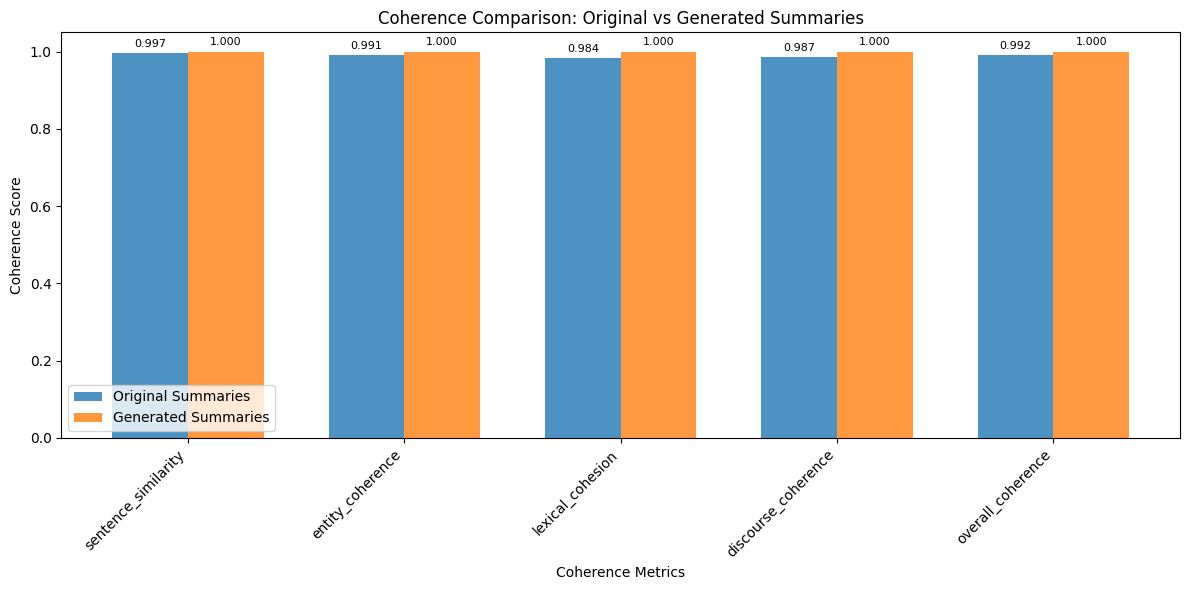


=== EVALUATION COMPLETE ===
Total samples evaluated: 1001
Results saved to: /content/drive/MyDrive/Thesis_Dataset/mT5_coherence_evaluation_results.xlsx


In [ ]:
# Bangla Abstractive Summary Coherence Evaluation
# This notebook evaluates coherence of Bangla summaries using various approaches

# Step 1: Mount Google Drive
from google.colab import drive
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
import re

# Mount Google Drive
drive.mount('/content/drive')

# Step 2: Install required packages
!pip install sentence-transformers
!pip install transformers
!pip install torch
!pip install nltk
!pip install textstat

# Import additional libraries
import nltk
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import torch
from sklearn.metrics.pairwise import cosine_similarity
import textstat

# Download NLTK data
nltk.download('punkt')

# Step 3: Load your Excel file
# Replace 'path/to/your/file.xlsx' with your actual file path in Google Drive
file_path = '/content/drive/MyDrive/Thesis_Dataset/test_data_with_summaries_mt5.xlsx'  # Update this path
df = pd.read_excel(file_path)

print("Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(df.head())

# Step 4: Bangla Text Preprocessing
def preprocess_bangla_text(text):
    """Basic preprocessing for Bangla text"""
    if pd.isna(text):
        return ""

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', str(text))

    # Remove special characters but keep Bangla characters
    text = re.sub(r'[^\u0980-\u09FF\s\.\,\?\!\;\:]', '', text)

    return text.strip()

# Step 5: Sentence Segmentation for Bangla
def segment_bangla_sentences(text):
    """Segment Bangla text into sentences"""
    if not text:
        return []

    # Basic sentence segmentation for Bangla
    sentences = re.split(r'[।\.\!\?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    return sentences

# Step 6: Coherence Evaluation Methods

class BanglaCoherenceEvaluator:
    def __init__(self):
        # Load multilingual sentence transformer model
        self.model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

    def sentence_similarity_coherence(self, summary: str) -> float:
        """
        Evaluate coherence based on sentence-to-sentence similarity
        Higher similarity between consecutive sentences indicates better coherence
        """
        sentences = segment_bangla_sentences(summary)

        if len(sentences) < 2:
            return 1.0  # Single sentence is inherently coherent

        # Get sentence embeddings
        embeddings = self.model.encode(sentences)

        # Calculate similarity between consecutive sentences
        similarities = []
        for i in range(len(embeddings) - 1):
            sim = cosine_similarity([embeddings[i]], [embeddings[i+1]])[0][0]
            similarities.append(sim)

        # Return average similarity
        return np.mean(similarities)

    def entity_coherence(self, summary: str) -> float:
        """
        Evaluate coherence based on entity consistency
        (Simplified version - you might want to use a Bangla NER model)
        """
        sentences = segment_bangla_sentences(summary)

        if len(sentences) < 2:
            return 1.0

        # Simple entity extraction (words that appear multiple times)
        all_words = []
        sentence_words = []

        for sentence in sentences:
            words = sentence.split()
            sentence_words.append(set(words))
            all_words.extend(words)

        # Find common entities (words appearing in multiple sentences)
        word_counts = {}
        for word in all_words:
            word_counts[word] = word_counts.get(word, 0) + 1

        entities = [word for word, count in word_counts.items() if count > 1]

        if not entities:
            return 0.5  # No repeated entities

        # Calculate entity distribution across sentences
        entity_scores = []
        for entity in entities:
            appearances = sum(1 for sent_words in sentence_words if entity in sent_words)
            score = appearances / len(sentences)
            entity_scores.append(score)

        return np.mean(entity_scores) if entity_scores else 0.5

    def lexical_cohesion(self, summary: str) -> float:
        """
        Evaluate lexical cohesion - repetition of words/phrases
        """
        sentences = segment_bangla_sentences(summary)

        if len(sentences) < 2:
            return 1.0

        all_words = []
        for sentence in sentences:
            words = sentence.split()
            all_words.extend(words)

        # Calculate lexical repetition
        word_counts = {}
        for word in all_words:
            word_counts[word] = word_counts.get(word, 0) + 1

        total_words = len(all_words)
        unique_words = len(word_counts)

        # Lexical cohesion score (higher repetition = higher cohesion)
        repetition_score = 1 - (unique_words / total_words)

        return repetition_score

    def discourse_coherence(self, summary: str) -> float:
        """
        Evaluate discourse coherence using transition indicators
        """
        sentences = segment_bangla_sentences(summary)

        if len(sentences) < 2:
            return 1.0

        # Bangla discourse markers/connectives
        discourse_markers = [
            'কিন্তু', 'তবে', 'সুতরাং', 'অতএব', 'তাই', 'যেহেতু',
            'কারণ', 'ফলে', 'এছাড়াও', 'তাছাড়া', 'অন্যদিকে',
            'প্রথমে', 'দ্বিতীয়ত', 'শেষে', 'সবশেষে', 'অবশেষে'
        ]

        marker_count = 0
        for sentence in sentences:
            for marker in discourse_markers:
                if marker in sentence:
                    marker_count += 1
                    break

        # Normalize by number of sentences
        discourse_score = marker_count / len(sentences)

        return min(discourse_score, 1.0)

    def overall_coherence(self, summary: str) -> Dict[str, float]:
        """
        Calculate overall coherence score combining multiple metrics
        """
        sentence_sim = self.sentence_similarity_coherence(summary)
        entity_coh = self.entity_coherence(summary)
        lexical_coh = self.lexical_cohesion(summary)
        discourse_coh = self.discourse_coherence(summary)

        # Weighted average (you can adjust weights based on your needs)
        overall = (sentence_sim * 0.4 + entity_coh * 0.3 +
                  lexical_coh * 0.2 + discourse_coh * 0.1)

        return {
            'sentence_similarity': sentence_sim,
            'entity_coherence': entity_coh,
            'lexical_cohesion': lexical_coh,
            'discourse_coherence': discourse_coh,
            'overall_coherence': overall
        }

# Step 7: Apply Coherence Evaluation
print("Initializing coherence evaluator...")
evaluator = BanglaCoherenceEvaluator()

# Preprocess your data
df['text_clean'] = df['text'].apply(preprocess_bangla_text)
df['summary_clean'] = df['summary'].apply(preprocess_bangla_text)
df['generated_summary_clean'] = df['generated_summary'].apply(preprocess_bangla_text)

print("Evaluating coherence for original summaries...")
# Evaluate original summaries
original_coherence = []
for idx, summary in enumerate(df['summary_clean']):
    if idx % 10 == 0:  # Progress indicator
        print(f"Processing original summary {idx+1}/{len(df)}")

    scores = evaluator.overall_coherence(summary)
    original_coherence.append(scores)

print("Evaluating coherence for generated summaries...")
# Evaluate generated summaries
generated_coherence = []
for idx, summary in enumerate(df['generated_summary_clean']):
    if idx % 10 == 0:  # Progress indicator
        print(f"Processing generated summary {idx+1}/{len(df)}")

    scores = evaluator.overall_coherence(summary)
    generated_coherence.append(scores)

# Step 8: Create Results DataFrame
results_df = pd.DataFrame()
results_df['text'] = df['text']
results_df['original_summary'] = df['summary']
results_df['generated_summary'] = df['generated_summary']

# Add coherence scores
for metric in ['sentence_similarity', 'entity_coherence', 'lexical_cohesion',
               'discourse_coherence', 'overall_coherence']:
    results_df[f'original_{metric}'] = [score[metric] for score in original_coherence]
    results_df[f'generated_{metric}'] = [score[metric] for score in generated_coherence]

# Step 9: Analysis and Comparison
print("\n=== COHERENCE EVALUATION RESULTS ===")
print("\nOriginal Summaries - Average Coherence Scores:")
for metric in ['sentence_similarity', 'entity_coherence', 'lexical_cohesion',
               'discourse_coherence', 'overall_coherence']:
    avg_score = np.mean([score[metric] for score in original_coherence])
    print(f"{metric}: {avg_score:.4f}")

print("\nGenerated Summaries - Average Coherence Scores:")
for metric in ['sentence_similarity', 'entity_coherence', 'lexical_cohesion',
               'discourse_coherence', 'overall_coherence']:
    avg_score = np.mean([score[metric] for score in generated_coherence])
    print(f"{metric}: {avg_score:.4f}")

# Step 10: Detailed Analysis
print("\n=== DETAILED COMPARISON ===")
comparison_metrics = []
for metric in ['sentence_similarity', 'entity_coherence', 'lexical_cohesion',
               'discourse_coherence', 'overall_coherence']:
    original_avg = np.mean([score[metric] for score in original_coherence])
    generated_avg = np.mean([score[metric] for score in generated_coherence])
    difference = generated_avg - original_avg

    comparison_metrics.append({
        'metric': metric,
        'original_avg': original_avg,
        'generated_avg': generated_avg,
        'difference': difference,
        'improvement': 'Yes' if difference > 0 else 'No'
    })

comparison_df = pd.DataFrame(comparison_metrics)
print(comparison_df.to_string(index=False))

# Step 11: Save Results
output_path = '/content/drive/MyDrive/Thesis_Dataset/mT5_coherence_evaluation_results.xlsx'
results_df.to_excel(output_path, index=False)
print(f"\nResults saved to: {output_path}")

# Step 12: Visualization (Optional)
import matplotlib.pyplot as plt

# Plot comparison
metrics = ['sentence_similarity', 'entity_coherence', 'lexical_cohesion',
           'discourse_coherence', 'overall_coherence']
original_scores = [np.mean([score[metric] for score in original_coherence]) for metric in metrics]
generated_scores = [np.mean([score[metric] for score in generated_coherence]) for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, original_scores, width, label='Original Summaries', alpha=0.8)
bars2 = ax.bar(x + width/2, generated_scores, width, label='Generated Summaries', alpha=0.8)

ax.set_xlabel('Coherence Metrics')
ax.set_ylabel('Coherence Score')
ax.set_title('Coherence Comparison: Original vs Generated Summaries')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\n=== EVALUATION COMPLETE ===")
print(f"Total samples evaluated: {len(df)}")
print(f"Results saved to: {output_path}")

**Only BERTScore**

In [ ]:
# ============================================
# BERTSCORE EVALUATION WITH GOOGLE DRIVE
# ============================================

# Install required packages
!pip install transformers torch pandas numpy scikit-learn openpyxl
#!pip install google-colab-helper gdown

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ============================================
# IMPORTS
# ============================================

import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# ============================================
# BANGLABERT-BASED SIMILARITY EVALUATOR
# ============================================

class BanglaBERTEvaluator:
    def __init__(self, device=None):
        """
        Initialize with BanglaBERT model
        """
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"

        self.device = device
        print(f"Loading BanglaBERT model on {device}...")

        # Load BanglaBERT
        self.tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")
        self.model = AutoModel.from_pretrained("csebuetnlp/banglabert").to(device)
        self.model.eval()

        print("BanglaBERT loaded successfully!")

    def get_embedding(self, text):
        """
        Get BERT embedding for a text
        """
        # Handle empty or None text
        if not text or pd.isna(text):
            text = ""

        # Tokenize
        inputs = self.tokenizer(
            str(text),
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )

        # Move to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)
            # Use [CLS] token embedding
            embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token

        return embeddings

    def calculate_similarity(self, reference, candidate):
        """
        Calculate cosine similarity between reference and candidate
        """
        ref_emb = self.get_embedding(reference)
        cand_emb = self.get_embedding(candidate)

        # Calculate cosine similarity
        similarity = F.cosine_similarity(ref_emb, cand_emb, dim=1)
        return similarity.item()

    def evaluate_dataframe(self, df, reference_col, candidate_col):
        """
        Evaluate summaries from DataFrame
        """
        print(f"Evaluating {len(df)} summary pairs...")

        similarities = []
        for i in range(len(df)):
            ref = df.iloc[i][reference_col]
            cand = df.iloc[i][candidate_col]

            similarity = self.calculate_similarity(ref, cand)
            similarities.append(similarity)

            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(df)} pairs")

        return similarities

# ============================================
# EXCEL PROCESSING FUNCTIONS
# ============================================

def load_excel_from_drive(file_path):
    """
    Load Excel file from Google Drive
    """
    try:
        df = pd.read_excel(file_path)
        print(f"Successfully loaded Excel file with {len(df)} rows")
        print(f"Columns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"Error loading Excel file: {e}")
        return None

def save_excel_to_drive(df, file_path):
    """
    Save DataFrame to Excel in Google Drive
    """
    try:
        df.to_excel(file_path, index=False)
        print(f"Successfully saved results to: {file_path}")
        return True
    except Exception as e:
        print(f"Error saving Excel file: {e}")
        return False

def process_dataset_with_bertscore(input_file_path, output_file_path,
                                  reference_col='summary', #summary text bangla t5 mbart, Summary Text Mt5,nllb
                                  candidate_col='generated_summary',
                                  data_col='text'):
    """
    Main function to process dataset with BERTScore evaluation
    """
    # Load the dataset
    print("=== Loading Dataset ===")
    df = load_excel_from_drive(input_file_path)

    if df is None:
        return None

    # Check if required columns exist
    required_cols = [reference_col, candidate_col]
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Error: Missing columns: {missing_cols}")
        print(f"Available columns: {list(df.columns)}")
        return None

    # Clean data - remove rows with empty summaries
    print("=== Cleaning Data ===")
    initial_rows = len(df)
    df = df.dropna(subset=[reference_col, candidate_col])
    df = df[df[reference_col].str.strip() != '']
    df = df[df[candidate_col].str.strip() != '']

    print(f"Removed {initial_rows - len(df)} rows with empty summaries")
    print(f"Processing {len(df)} rows")

    if len(df) == 0:
        print("No valid data to process!")
        return None

    # Initialize evaluator
    print("=== Initializing BanglaBERT Evaluator ===")
    evaluator = BanglaBERTEvaluator()

    # Calculate BERTScores
    print("=== Calculating BERTScores ===")
    bert_scores = evaluator.evaluate_dataframe(df, reference_col, candidate_col)

    # Add BERTScore column to dataframe
    df['bertscore'] = bert_scores

    # Calculate statistics
    avg_bertscore = np.mean(bert_scores)
    std_bertscore = np.std(bert_scores)
    min_bertscore = np.min(bert_scores)
    max_bertscore = np.max(bert_scores)

    # Create results summary
    print("=== Results Summary ===")
    print(f"Total pairs evaluated: {len(bert_scores)}")
    print(f"Average BERTScore: {avg_bertscore:.4f}")
    print(f"Standard Deviation: {std_bertscore:.4f}")
    print(f"Min BERTScore: {min_bertscore:.4f}")
    print(f"Max BERTScore: {max_bertscore:.4f}")

    # Add summary statistics to the dataframe
    summary_stats = pd.DataFrame({
        'Metric': ['Average BERTScore', 'Standard Deviation', 'Min BERTScore', 'Max BERTScore', 'Total Pairs'],
        'Value': [avg_bertscore, std_bertscore, min_bertscore, max_bertscore, len(bert_scores)]
    })

    # Create output with both data and summary
    output_df = df.copy()

    # Reorder columns to put bertscore at the end
    if data_col in output_df.columns:
        cols = [data_col, reference_col, candidate_col, 'bertscore']
    else:
        cols = [reference_col, candidate_col, 'bertscore']

    # Add any other columns that might exist
    other_cols = [col for col in output_df.columns if col not in cols]
    cols.extend(other_cols)

    output_df = output_df[cols]

    # Save results to Excel
    print("=== Saving Results ===")
    with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
        output_df.to_excel(writer, sheet_name='Results', index=False)
        summary_stats.to_excel(writer, sheet_name='Summary_Statistics', index=False)

    print(f"Results saved to: {output_file_path}")

    return {
        'dataframe': output_df,
        'statistics': {
            'average': avg_bertscore,
            'std': std_bertscore,
            'min': min_bertscore,
            'max': max_bertscore,
            'count': len(bert_scores)
        },
        'all_scores': bert_scores
    }

# ============================================
# USAGE EXAMPLE
# ============================================

# Define file paths - UPDATE THESE PATHS
input_file_path = '/content/drive/MyDrive/Thesis_Dataset/BanglaT5.xlsx'  # Change this to your input file path
#test_data_with_summaries_mt5
#Banglat5_10K
#test_data_with_summaries_mBART_3epoch
#test_data_with_summaries_NLLB_12
output_file_path = '/content/drive/MyDrive/Thesis_Dataset/BanglaT5_BERTSCore.xlsx'  # Change this to your desired output path
#bertscore_results_mt5
#bertscore_results_mbart
#bertscore_results_nllb

# Column names in your Excel file - UPDATE THESE IF DIFFERENT
reference_column = 'summary'          # Column name for reference summaries
candidate_column = 'generated_summary'  # Column name for generated summaries
data_column = 'text'                  # Column name for original data (optional)
#-------------------------------------------------------------------------------------------- #summary text bangla t5 mbart, Summary Text Mt5,nllb
# Process the dataset
print("=== Starting BERTScore Evaluation ===")
results = process_dataset_with_bertscore(
    input_file_path=input_file_path,
    output_file_path=output_file_path,
    reference_col=reference_column,
    candidate_col=candidate_column,
    data_col=data_column
)

if results:
    print("=== Final Results ===")
    print(f"✅ Processing completed successfully!")
    print(f"📊 Average BERTScore: {results['statistics']['average']:.4f}")
    print(f"📁 Output saved to: {output_file_path}")

    # Display first few rows of results
    print("\n=== Sample Results ===")
    print(results['dataframe'].head())

    # Display score distribution
    scores = results['all_scores']
    print(f"\n=== Score Distribution ===")
    print(f"Scores > 0.8: {sum(1 for s in scores if s > 0.8)} ({sum(1 for s in scores if s > 0.8)/len(scores)*100:.1f}%)")
    print(f"Scores > 0.7: {sum(1 for s in scores if s > 0.7)} ({sum(1 for s in scores if s > 0.7)/len(scores)*100:.1f}%)")
    print(f"Scores > 0.6: {sum(1 for s in scores if s > 0.6)} ({sum(1 for s in scores if s > 0.6)/len(scores)*100:.1f}%)")

else:
    print("❌ Processing failed. Please check your file paths and column names.")


# ============================================
# INSTRUCTIONS FOR USE
# ============================================

print("\n" + "="*50)
print("INSTRUCTIONS FOR USE:")
print("="*50)
print("1. Update the file paths:")
print("   - input_file_path: Path to your Excel file in Google Drive")
print("   - output_file_path: Where you want to save the results")
print()
print("2. Update column names if different:")
print("   - reference_column: Column with reference summaries")
print("   - candidate_column: Column with generated summaries")
print("   - data_column: Column with original data (optional)")
print()
print("3. Run the script - it will:")
print("   - Load your Excel file")
print("   - Calculate BERTScores using BanglaBERT")
print("   - Save results with BERTScore column")
print("   - Print average BERTScore and statistics")
print()
print("4. The output Excel will have two sheets:")
print("   - Results: Your data with BERTScore column")
print("   - Summary_Statistics: Overall statistics")
print("="*50)

# Example for previewing your file first
#print("\n=== Preview Your File (Optional) ===")
#print("# Uncomment the next line to preview your Excel file first:")
#print("# quick_preview_excel('/content/drive/MyDrive/your_input_file.xlsx')")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.6.0+cu124
CUDA available: True
=== Starting BERTScore Evaluation ===
=== Loading Dataset ===
Successfully loaded Excel file with 1 rows
Columns: ['summary', 'generated_summary']
=== Cleaning Data ===
Removed 0 rows with empty summaries
Processing 1 rows
=== Initializing BanglaBERT Evaluator ===
Loading BanglaBERT model on cuda...


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

BanglaBERT loaded successfully!
=== Calculating BERTScores ===
Evaluating 1 summary pairs...
=== Results Summary ===
Total pairs evaluated: 1
Average BERTScore: 0.9347
Standard Deviation: 0.0000
Min BERTScore: 0.9347
Max BERTScore: 0.9347
=== Saving Results ===
Results saved to: /content/drive/MyDrive/Thesis_Dataset/BanglaT5_BERTSCore.xlsx
=== Final Results ===
✅ Processing completed successfully!
📊 Average BERTScore: 0.9347
📁 Output saved to: /content/drive/MyDrive/Thesis_Dataset/BanglaT5_BERTSCore.xlsx

=== Sample Results ===
                                             summary  \
0  এই লেকচারে শিক্ষক ডিএসডি কোর্সের প্রাথমিক পরিচ...   

                                   generated_summary  bertscore  
0  এই অংশে, ডিএসডি এবং ডিজিটাল সিস্টেম সম্পর্কে আ...   0.934715  

=== Score Distribution ===
Scores > 0.8: 1 (100.0%)
Scores > 0.7: 1 (100.0%)
Scores > 0.6: 1 (100.0%)

INSTRUCTIONS FOR USE:
1. Update the file paths:
   - input_file_path: Path to your Excel file in Google Drive
   - ou

**Full** **BERTScore**

In [ ]:
# ============================================
# FULL BERTSCORE EVALUATION WITH GOOGLE DRIVE----------------lagpe na
# ============================================

# Install required packages
!pip install transformers torch pandas numpy scikit-learn openpyxl
#!pip install google-colab-helper gdown

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ============================================
# IMPORTS
# ============================================

import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# ============================================
# FULL BERTSCORE EVALUATOR
# ============================================

class FullBERTScoreEvaluator:
    def __init__(self, device=None, model_name="csebuetnlp/banglabert"):
        """
        Initialize with BanglaBERT model for full BERTScore calculation
        """
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"

        self.device = device
        self.model_name = model_name
        print(f"Loading {model_name} model on {device}...")

        # Load BanglaBERT
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.model.eval()

        print(f"{model_name} loaded successfully!")

    def get_token_embeddings(self, text):
        """
        Get token-level embeddings for BERTScore calculation
        """
        # Handle empty or None text
        if not text or pd.isna(text):
            text = ""

        # Tokenize
        inputs = self.tokenizer(
            str(text),
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512,
            add_special_tokens=True
        )

        # Move to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)
            # Get all token embeddings (not just CLS)
            embeddings = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        return embeddings, inputs['input_ids'], inputs['attention_mask']

    def calculate_bertscore(self, reference, candidate, verbose=False):
        """
        Calculate full BERTScore with precision, recall, and F1
        """
        # Get token embeddings for both texts
        ref_emb, ref_ids, ref_mask = self.get_token_embeddings(reference)
        cand_emb, cand_ids, cand_mask = self.get_token_embeddings(candidate)

        # Remove batch dimension
        ref_emb = ref_emb.squeeze(0)  # (ref_len, hidden_size)
        cand_emb = cand_emb.squeeze(0)  # (cand_len, hidden_size)
        ref_ids = ref_ids.squeeze(0)  # (ref_len,)
        cand_ids = cand_ids.squeeze(0)  # (cand_len,)
        ref_mask = ref_mask.squeeze(0)  # (ref_len,)
        cand_mask = cand_mask.squeeze(0)  # (cand_len,)

        # Get valid token positions (excluding padding)
        ref_valid = ref_mask.bool()
        cand_valid = cand_mask.bool()

        # Extract valid embeddings
        ref_emb_valid = ref_emb[ref_valid]  # (ref_valid_len, hidden_size)
        cand_emb_valid = cand_emb[cand_valid]  # (cand_valid_len, hidden_size)

        # Skip special tokens for scoring (CLS, SEP, PAD)
        special_tokens = {
            self.tokenizer.cls_token_id,
            self.tokenizer.sep_token_id,
            self.tokenizer.pad_token_id,
            self.tokenizer.unk_token_id
        }

        # Find non-special token positions
        ref_content_mask = ~torch.isin(ref_ids[ref_valid], torch.tensor(list(special_tokens)).to(self.device))
        cand_content_mask = ~torch.isin(cand_ids[cand_valid], torch.tensor(list(special_tokens)).to(self.device))

        # Extract content token embeddings
        ref_content_emb = ref_emb_valid[ref_content_mask]
        cand_content_emb = cand_emb_valid[cand_content_mask]

        if len(ref_content_emb) == 0 or len(cand_content_emb) == 0:
            return {"precision": 0.0, "recall": 0.0, "f1": 0.0}

        # Calculate pairwise cosine similarities
        # ref_content_emb: (ref_content_len, hidden_size)
        # cand_content_emb: (cand_content_len, hidden_size)
        similarity_matrix = F.cosine_similarity(
            ref_content_emb.unsqueeze(1),  # (ref_content_len, 1, hidden_size)
            cand_content_emb.unsqueeze(0),  # (1, cand_content_len, hidden_size)
            dim=2
        )  # (ref_content_len, cand_content_len)

        # Calculate precision: for each candidate token, find max similarity with reference tokens
        precision_scores = torch.max(similarity_matrix, dim=0)[0]  # (cand_content_len,)
        precision = torch.mean(precision_scores).item()

        # Calculate recall: for each reference token, find max similarity with candidate tokens
        recall_scores = torch.max(similarity_matrix, dim=1)[0]  # (ref_content_len,)
        recall = torch.mean(recall_scores).item()

        # Calculate F1 score
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * precision * recall / (precision + recall)

        if verbose:
            print(f"Reference tokens: {len(ref_content_emb)}")
            print(f"Candidate tokens: {len(cand_content_emb)}")
            print(f"Similarity matrix shape: {similarity_matrix.shape}")

        return {
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    def evaluate_dataframe(self, df, reference_col, candidate_col):
        """
        Evaluate summaries from DataFrame with full BERTScore metrics
        """
        print(f"Evaluating {len(df)} summary pairs...")

        precision_scores = []
        recall_scores = []
        f1_scores = []

        for i in range(len(df)):
            ref = df.iloc[i][reference_col]
            cand = df.iloc[i][candidate_col]

            scores = self.calculate_bertscore(ref, cand)
            precision_scores.append(scores['precision'])
            recall_scores.append(scores['recall'])
            f1_scores.append(scores['f1'])

            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(df)} pairs")

        return {
            'precision': precision_scores,
            'recall': recall_scores,
            'f1': f1_scores
        }

# ============================================
# EXCEL PROCESSING FUNCTIONS
# ============================================

def load_excel_from_drive(file_path):
    """
    Load Excel file from Google Drive
    """
    try:
        df = pd.read_excel(file_path)
        print(f"Successfully loaded Excel file with {len(df)} rows")
        print(f"Columns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"Error loading Excel file: {e}")
        return None

def save_excel_to_drive(df, file_path):
    """
    Save DataFrame to Excel in Google Drive
    """
    try:
        df.to_excel(file_path, index=False)
        print(f"Successfully saved results to: {file_path}")
        return True
    except Exception as e:
        print(f"Error saving Excel file: {e}")
        return False

def process_dataset_with_full_bertscore(input_file_path, output_file_path,
                                       reference_col='summary',
                                       candidate_col='generated_summary',
                                       data_col='text',
                                       model_name="csebuetnlp/banglabert"):
    """
    Main function to process dataset with full BERTScore evaluation
    """
    # Load the dataset
    print("=== Loading Dataset ===")
    df = load_excel_from_drive(input_file_path)

    if df is None:
        return None

    # Check if required columns exist
    required_cols = [reference_col, candidate_col]
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Error: Missing columns: {missing_cols}")
        print(f"Available columns: {list(df.columns)}")
        return None

    # Clean data - remove rows with empty summaries
    print("=== Cleaning Data ===")
    initial_rows = len(df)
    df = df.dropna(subset=[reference_col, candidate_col])
    df = df[df[reference_col].str.strip() != '']
    df = df[df[candidate_col].str.strip() != '']

    print(f"Removed {initial_rows - len(df)} rows with empty summaries")
    print(f"Processing {len(df)} rows")

    if len(df) == 0:
        print("No valid data to process!")
        return None

    # Initialize evaluator
    print("=== Initializing Full BERTScore Evaluator ===")
    evaluator = FullBERTScoreEvaluator(model_name=model_name)

    # Calculate BERTScores
    print("=== Calculating Full BERTScores ===")
    bert_scores = evaluator.evaluate_dataframe(df, reference_col, candidate_col)

    # Add BERTScore columns to dataframe
    df['bertscore_precision'] = bert_scores['precision']
    df['bertscore_recall'] = bert_scores['recall']
    df['bertscore_f1'] = bert_scores['f1']

    # Calculate statistics
    metrics = ['precision', 'recall', 'f1']
    statistics = {}

    for metric in metrics:
        scores = bert_scores[metric]
        statistics[metric] = {
            'average': np.mean(scores),
            'std': np.std(scores),
            'min': np.min(scores),
            'max': np.max(scores),
            'median': np.median(scores)
        }

    # Create results summary
    print("=== Results Summary ===")
    print(f"Total pairs evaluated: {len(bert_scores['f1'])}")
    for metric in metrics:
        stats = statistics[metric]
        print(f"{metric.capitalize()} - Avg: {stats['average']:.4f}, Std: {stats['std']:.4f}, Min: {stats['min']:.4f}, Max: {stats['max']:.4f}")

    # Create detailed summary statistics DataFrame
    summary_rows = []
    for metric in metrics:
        stats = statistics[metric]
        summary_rows.extend([
            [f'{metric.capitalize()} - Average', stats['average']],
            [f'{metric.capitalize()} - Standard Deviation', stats['std']],
            [f'{metric.capitalize()} - Minimum', stats['min']],
            [f'{metric.capitalize()} - Maximum', stats['max']],
            [f'{metric.capitalize()} - Median', stats['median']]
        ])

    summary_rows.append(['Total Pairs', len(bert_scores['f1'])])

    summary_stats = pd.DataFrame(summary_rows, columns=['Metric', 'Value'])

    # Create score distribution analysis
    f1_scores = bert_scores['f1']
    distribution_data = []
    thresholds = [0.9, 0.8, 0.7, 0.6, 0.5]

    for threshold in thresholds:
        count = sum(1 for s in f1_scores if s >= threshold)
        percentage = (count / len(f1_scores)) * 100
        distribution_data.append([f'F1 >= {threshold}', count, f'{percentage:.1f}%'])

    distribution_df = pd.DataFrame(distribution_data, columns=['Threshold', 'Count', 'Percentage'])

    # Create output with reordered columns
    output_df = df.copy()

    # Reorder columns to put bertscore metrics at the end
    if data_col in output_df.columns:
        base_cols = [data_col, reference_col, candidate_col]
    else:
        base_cols = [reference_col, candidate_col]

    bertscore_cols = ['bertscore_precision', 'bertscore_recall', 'bertscore_f1']

    # Add any other columns that might exist
    other_cols = [col for col in output_df.columns if col not in base_cols + bertscore_cols]

    final_cols = base_cols + other_cols + bertscore_cols
    output_df = output_df[final_cols]

    # Save results to Excel with multiple sheets
    print("=== Saving Results ===")
    with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
        output_df.to_excel(writer, sheet_name='Results', index=False)
        summary_stats.to_excel(writer, sheet_name='Summary_Statistics', index=False)
        distribution_df.to_excel(writer, sheet_name='Score_Distribution', index=False)

    print(f"Results saved to: {output_file_path}")

    return {
        'dataframe': output_df,
        'statistics': statistics,
        'all_scores': bert_scores,
        'distribution': distribution_df
    }

# ============================================
# USAGE EXAMPLE
# ============================================

# Define file paths - UPDATE THESE PATHS
input_file_path = '/content/drive/MyDrive/Thesis_Dataset/test_Qwen_raw.xlsx'  # Change this to your input file path
output_file_path = '/content/drive/MyDrive/Thesis_Dataset/bertscore_Qwen_raw.xlsx'  # Change this to your desired output path

# test_data_with_summaries_Banglat5_10K.xlsx
# test_data_with_summaries_NLLB_12.xlsx
#test_data_with_summaries_mBART_3epoch
#test_data_with_summaries_mt5

# Column names in your Excel file - UPDATE THESE IF DIFFERENT #t,s for bt5 mbart , T,S for nllb mt5
reference_column = 'summary'          # Column name for reference summaries
candidate_column = 'generated_summary'  # Column name for generated summaries
data_column = 'Text'                  # Column name for original data (optional)

# Model name - you can change this to other BERT models
model_name = "csebuetnlp/banglabert"  # or "bert-base-multilingual-cased" for multilingual

# Process the dataset
print("=== Starting Full BERTScore Evaluation ===")
results = process_dataset_with_full_bertscore(
    input_file_path=input_file_path,
    output_file_path=output_file_path,
    reference_col=reference_column,
    candidate_col=candidate_column,
    data_col=data_column,
    model_name=model_name
)

if results:
    print("=== Final Results ===")
    print(f"✅ Processing completed successfully!")

    stats = results['statistics']
    print(f"📊 Average BERTScore Precision: {stats['precision']['average']:.4f}")
    print(f"📊 Average BERTScore Recall: {stats['recall']['average']:.4f}")
    print(f"📊 Average BERTScore F1: {stats['f1']['average']:.4f}")
    print(f"📁 Output saved to: {output_file_path}")

    # Display first few rows of results
    print("\n=== Sample Results ===")
    print(results['dataframe'][['summary', 'generated_summary', 'bertscore_precision', 'bertscore_recall', 'bertscore_f1']].head()) #---------change

    # Display score distribution
    print(f"\n=== F1 Score Distribution ===")
    print(results['distribution'].to_string(index=False))

else:
    print("❌ Processing failed. Please check your file paths and column names.")

# ============================================
# ADDITIONAL UTILITY FUNCTIONS
# ============================================

def compare_models(input_file_path, output_dir, reference_col, candidate_col, data_col='text'):
    """
    Compare different BERT models for BERTScore evaluation
    """
    models = [
        "csebuetnlp/banglabert",
        "bert-base-multilingual-cased",
        "xlm-roberta-base"
    ]

    results_comparison = {}

    for model_name in models:
        print(f"\n=== Evaluating with {model_name} ===")

        output_file = os.path.join(output_dir, f"bertscore_results_{model_name.replace('/', '_')}.xlsx")

        try:
            results = process_dataset_with_full_bertscore(
                input_file_path=input_file_path,
                output_file_path=output_file,
                reference_col=reference_col,
                candidate_col=candidate_col,
                data_col=data_col,
                model_name=model_name
            )

            if results:
                results_comparison[model_name] = results['statistics']
                print(f"✅ {model_name} completed successfully!")
        except Exception as e:
            print(f"❌ Error with {model_name}: {e}")

    return results_comparison

def analyze_score_patterns(results_df):
    """
    Analyze patterns in BERTScore results
    """
    print("=== Score Pattern Analysis ===")

    # Correlation between precision and recall
    corr_pr = results_df['bertscore_precision'].corr(results_df['bertscore_recall'])
    print(f"Precision-Recall Correlation: {corr_pr:.4f}")

    # Find best and worst performing examples
    best_f1_idx = results_df['bertscore_f1'].idxmax()
    worst_f1_idx = results_df['bertscore_f1'].idxmin()

    print(f"\n=== Best F1 Score Example ===")
    print(f"F1: {results_df.loc[best_f1_idx, 'bertscore_f1']:.4f}")
    print(f"Reference: {results_df.loc[best_f1_idx, 'summary'][:100]}...")
    print(f"Candidate: {results_df.loc[best_f1_idx, 'generated_summary'][:100]}...")

    print(f"\n=== Worst F1 Score Example ===")
    print(f"F1: {results_df.loc[worst_f1_idx, 'bertscore_f1']:.4f}")
    print(f"Reference: {results_df.loc[worst_f1_idx, 'summary'][:100]}...")
    print(f"Candidate: {results_df.loc[worst_f1_idx, 'generated_summary'][:100]}...")

# ============================================
# INSTRUCTIONS FOR USE
# ============================================

print("\n" + "="*60)
print("INSTRUCTIONS FOR FULL BERTSCORE EVALUATION:")
print("="*60)
print("1. Update the file paths:")
print("   - input_file_path: Path to your Excel file in Google Drive")
print("   - output_file_path: Where you want to save the results")
print()
print("2. Update column names if different:")
print("   - reference_column: Column with reference summaries")
print("   - candidate_column: Column with generated summaries")
print("   - data_column: Column with original data (optional)")
print()
print("3. Choose your model:")
print("   - 'csebuetnlp/banglabert' for Bangla-specific evaluation")
print("   - 'bert-base-multilingual-cased' for multilingual evaluation")
print("   - 'xlm-roberta-base' for cross-lingual evaluation")
print()
print("4. Run the script - it will calculate:")
print("   - BERTScore Precision: Quality of generated text")
print("   - BERTScore Recall: Coverage of reference text")
print("   - BERTScore F1: Harmonic mean of precision and recall")
print()
print("5. The output Excel will have three sheets:")
print("   - Results: Your data with all BERTScore columns")
print("   - Summary_Statistics: Detailed statistics for all metrics")
print("   - Score_Distribution: Distribution analysis of F1 scores")
print()
print("6. Additional functions:")
print("   - compare_models(): Compare different BERT models")
print("   - analyze_score_patterns(): Analyze score patterns and examples")
print("="*60)

# Uncomment to run model comparison
# results_comparison = compare_models(
#     input_file_path='/content/drive/MyDrive/your_file.xlsx',
#     output_dir='/content/drive/MyDrive/',
#     reference_col='summary',
#     candidate_col='generated_summary'
# )

# Uncomment to analyze patterns (after running main evaluation)
# if results:
#     analyze_score_patterns(results['dataframe'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.6.0+cu124
CUDA available: False
=== Starting Full BERTScore Evaluation ===
=== Loading Dataset ===
Successfully loaded Excel file with 13 rows
Columns: ['text', 'summary', 'generated_summary']
=== Cleaning Data ===
Removed 0 rows with empty summaries
Processing 13 rows
=== Initializing Full BERTScore Evaluator ===
Loading csebuetnlp/banglabert model on cpu...
csebuetnlp/banglabert loaded successfully!
=== Calculating Full BERTScores ===
Evaluating 13 summary pairs...
Processed 10/13 pairs
=== Results Summary ===
Total pairs evaluated: 13
Precision - Avg: 0.8060, Std: 0.0127, Min: 0.7762, Max: 0.8215
Recall - Avg: 0.8147, Std: 0.0189, Min: 0.7872, Max: 0.8550
F1 - Avg: 0.8102, Std: 0.0125, Min: 0.7852, Max: 0.8379
=== Saving Results ===
Results saved to: /content/drive/MyDrive/Thesis_Dataset/bertscore_Qwen_raw.xlsx
=== Final Results ===
✅ Pr